# ECG Chart Visualization with XAI Overlay

This notebook demonstrates the `plot_ecg_chart` function which combines:
- **12-lead ECG visualization** in clinical style
- **Counterfactual overlay** for comparison
- **Attribution heatmap** for feature importance

## Contents
1. Basic ECG Visualization
2. ECG with Counterfactual Overlay
3. ECG with Attribution Heatmap
4. Full XAI Visualization (ECG + CF + Attribution)
5. Different Styles and Options

In [1]:
import sys
import json
import numpy as np

sys.path.append("../")

from execg.visualizer import plot_ecg_chart, plot_ecg_comparison

## 0. Load Sample Data

In [2]:
with open("../samples/data/sample.json", "r") as f:
    sample_data = json.load(f)
ecg_signal = np.array(list(sample_data["data"].values()))
print(f"Loaded sample ECG data: shape = {ecg_signal.shape}")

# Resample to 250Hz if needed (original is 500Hz)
if ecg_signal.shape[-1] == 5000:
    ecg_signal = ecg_signal[:, ::2]
    print(f"Resampled to 250Hz: shape = {ecg_signal.shape}")

# Add batch dimension: (12, 2500) -> (1, 12, 2500)
ecg = ecg_signal[np.newaxis, ...]
print(f"ECG array shape: {ecg.shape}  # (batch=1, leads=12, length)")

Loaded sample ECG data: shape = (12, 5000)
Resampled to 250Hz: shape = (12, 2500)
ECG array shape: (1, 12, 2500)  # (batch=1, leads=12, length)


## 1. Basic ECG Visualization

Simple 12-lead ECG display with clinical-style grid.

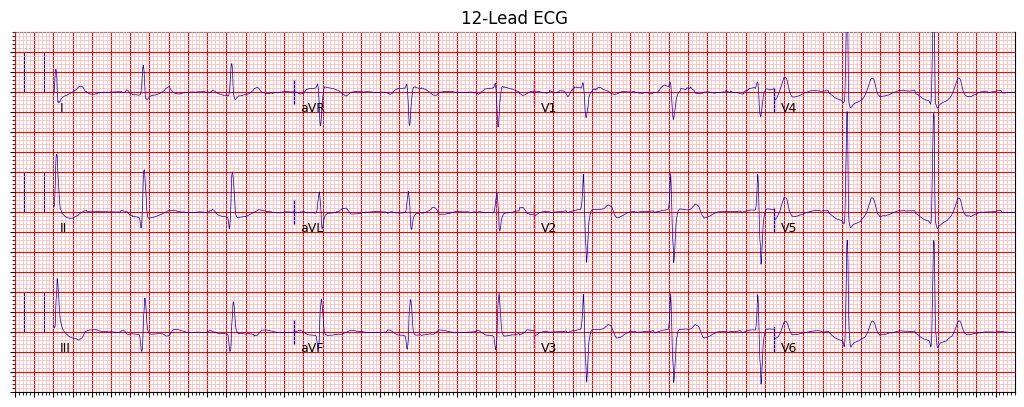

In [3]:
# Basic visualization
fig, axes = plot_ecg_chart(
    ecg,
    sample_rate=250,
    title="12-Lead ECG",
    style="clinical",  # Red grid style
    partial_continuous=True,
    show_calibration=True,
    columns=4
)

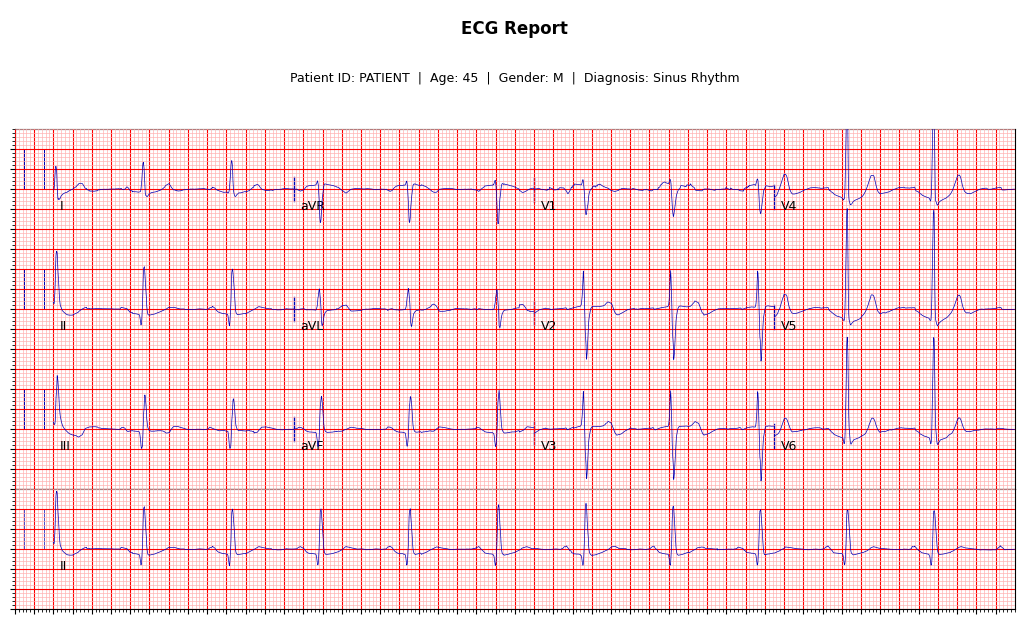

In [4]:
# With metadata
meta = {
    "Patient ID": "PATIENT",
    "Age": "45",
    "Gender": "M",
    "Diagnosis": "Sinus Rhythm",
}

fig, axes = plot_ecg_chart(
    ecg,
    sample_rate=250,
    meta=meta,
    title="ECG Report",
    style="clinical",
    partial_continuous=True,
    show_calibration=True,
    show_full_single_last=True,
    columns=4
)

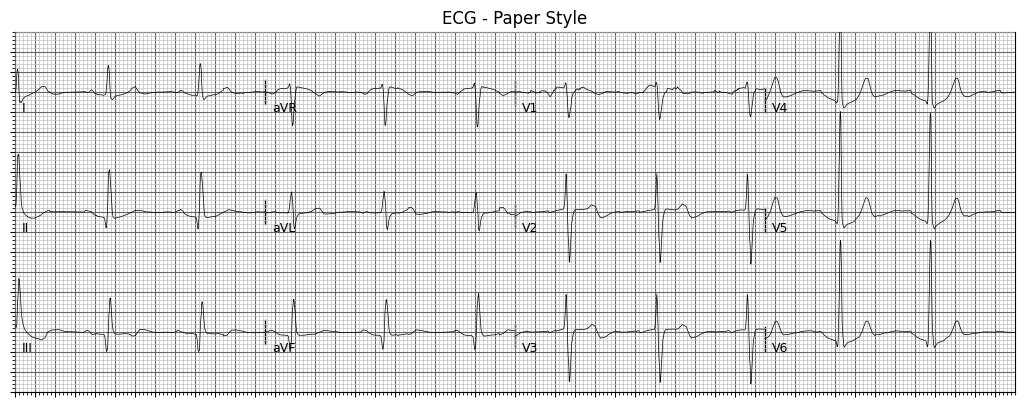

In [5]:
# Paper style (gray grid)
fig, axes = plot_ecg_chart(
    ecg,
    sample_rate=250,
    title="ECG - Paper Style",
    style="paper",
)

## 2. ECG with Counterfactual Overlay

Compare original ECG with counterfactual explanation.

In [6]:
# Generate synthetic counterfactual (in real usage, this comes from StyleGANCF)
# Simulate a CF that has slightly different morphology
np.random.seed(123)
cf_signal = ecg_signal.copy()

# Modify T-wave amplitude (simulating a prediction change)
for lead in range(12):
    for beat in range(10):
        t_idx = beat * 250 + 130
        if t_idx < 2500 - 40:
            # Increase T-wave amplitude
            cf_signal[lead, t_idx:t_idx+40] += 0.2 * np.sin(np.linspace(0, np.pi, 40))

# Add batch dimension: (12, 2500) -> (1, 12, 2500)
cf_ecg = cf_signal[np.newaxis, ...]
print(f"Counterfactual shape: {cf_ecg.shape}")

Counterfactual shape: (1, 12, 2500)


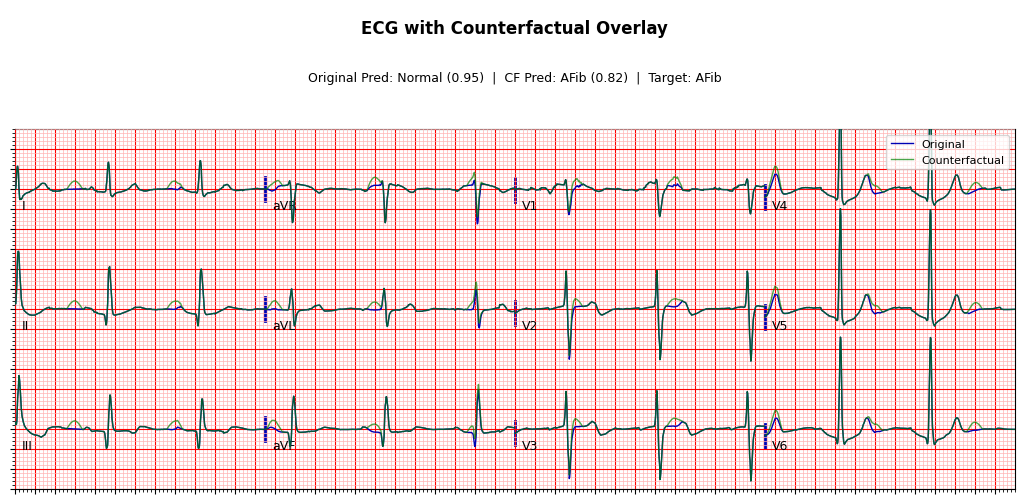

In [7]:
meta_cf = {
    "Original Pred": "Normal (0.95)",
    "CF Pred": "AFib (0.82)",
    "Target": "AFib",
}

# Visualize ECG with counterfactual overlay
fig, axes = plot_ecg_chart(
    ecg,
    sample_rate=250,
    cf_ecg=cf_ecg,
    meta=meta_cf,
    ecg_linewidth=1,
    title="ECG with Counterfactual Overlay",
    cf_color="green",
    cf_alpha=0.7,
    cf_label="Counterfactual",
    style="clinical",
)

## 3. ECG with Attribution Heatmap

Display feature importance using attribution scores.

In [8]:
# Generate synthetic attribution scores (in real usage, this comes from GradCAM/SaliencyMap)
np.random.seed(456)
attribution = np.zeros_like(ecg_signal)

# Simulate high importance in QRS complex and T-wave regions
for lead in range(12):
    for beat in range(10):
        # QRS region - high importance
        qrs_idx = beat * 250 + 70
        if qrs_idx < 2500 - 30:
            attribution[lead, qrs_idx:qrs_idx+30] = np.random.uniform(0.7, 1.0, 30)
        
        # T-wave region - medium importance
        t_idx = beat * 250 + 130
        if t_idx < 2500 - 40:
            attribution[lead, t_idx:t_idx+40] = np.random.uniform(0.3, 0.6, 40)

# Add some baseline noise
attribution += 0.05 * np.random.rand(*attribution.shape)
attribution = np.clip(attribution, 0, 1)

# Add batch dimension: (12, 2500) -> (1, 12, 2500)
attr = attribution[np.newaxis, ...]
print(f"Attribution shape: {attr.shape}")

Attribution shape: (1, 12, 2500)


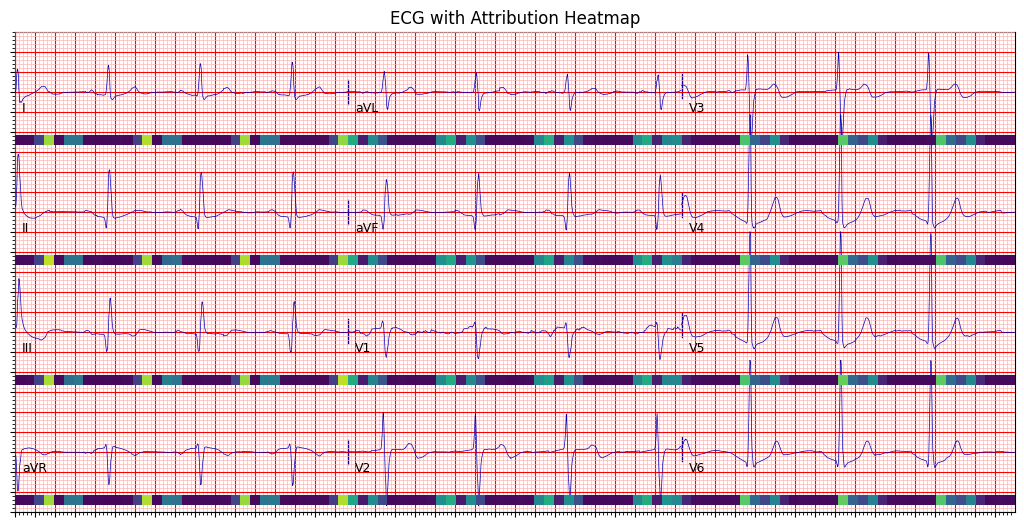

In [9]:
# Visualize ECG with attribution heatmap
fig, axes = plot_ecg_chart(
    ecg,
    sample_rate=250,
    attribution=attr,
    title="ECG with Attribution Heatmap",
    attr_bin_size=25,
    attr_cmap="viridis",
    style="clinical",
    columns=3
)

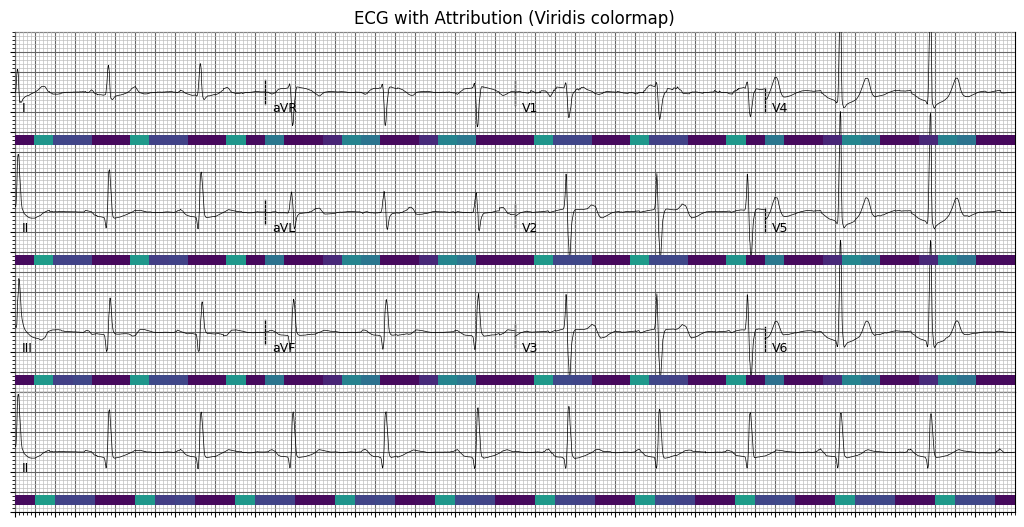

In [10]:
# Different colormap
fig, axes = plot_ecg_chart(
    ecg,
    sample_rate=250,
    attribution=attr,
    title="ECG with Attribution (Viridis colormap)",
    attr_bin_size=50,
    attr_cmap="viridis",
    style="paper",
    show_full_single_last=True
)

## 4. Full XAI Visualization

Combine all XAI elements: ECG + Counterfactual + Attribution

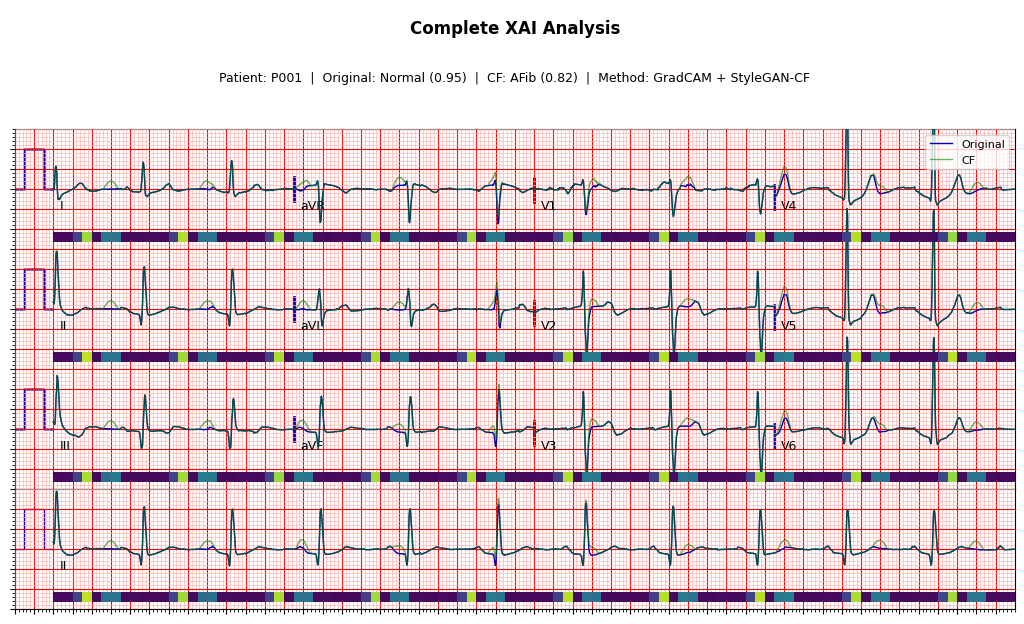

In [ ]:
# Full XAI visualization
meta_full = {
    "Patient": "P001",
    "Original": "Normal (0.95)",
    "Counterfactual": "AFib (0.82)",
    "TCAV report": "QTS W",
    "Method": "GradCAM + StyleGAN-CF",
}

fig, axes = plot_ecg_chart(
    ecg,
    sample_rate=250,
    cf_ecg=cf_ecg,
    ecg_linewidth=1,
    attribution=attr,
    meta=meta_full,
    title="Complete XAI Analysis",
    cf_color="green",
    cf_alpha=0.6,
    attr_bin_size=25,
    attr_cmap="viridis",
    style="clinical",
    columns=4,
    show_full_single_last=True,
    show_calibration=True,
    save_path='../tmp/paper/figures/ECGchart.png'
)

## 5. Different Layouts and Options

In [ ]:
# Single column layout
fig, axes = plot_ecg_chart(
    ecg,
    sample_rate=250,
    columns=1,
    title="12-Lead ECG (Single Column)",
    style="clinical",
    figsize=(14, 20),
)

In [ ]:
# 3-column layout
fig, axes = plot_ecg_chart(
    ecg,
    sample_rate=250,
    columns=3,
    title="12-Lead ECG (3 Columns)",
    style="clinical",
)

In [ ]:
# Without grid
fig, axes = plot_ecg_chart(
    ecg,
    sample_rate=250,
    cf_ecg=cf_ecg,
    title="ECG Comparison (No Grid)",
    show_grid=True,
    cf_color="orange",
)

## 6. ECG Comparison (Multiple Signals)

In [ ]:
# Compare multiple ECG signals
ecg_list = [ecg, cf_ecg]
labels = ["Original", "Counterfactual"]

fig, axes = plot_ecg_comparison(
    ecg_list,
    labels=labels,
    sample_rate=250,
    lead_idx=[1, 6],  # Lead II and V1
    title="ECG Comparison: Lead II and V1",
)

## 7. Real Usage with ExECG Models

In [ ]:
# Example with real model (uncomment to run)
"""
import torch
from execg.models import TorchModelWrapper
from execg.attribution import GradCAM
from execg.counterfactual import StyleGANCF
from samples.models import get_model

# Load model
model = get_model(
    name="afib_binary",
    model_dir="../tmp/models/afib_binary/",
    download=True,
)
wrapper = TorchModelWrapper(model)

# Convert to tensor for model inference
ecg_tensor = torch.tensor(ecg, dtype=torch.float32)

# Generate attribution
gradcam = GradCAM(wrapper)
layer_names = wrapper.get_layer_names()
conv_layers = [name for name in layer_names if 'conv' in name.lower()]
target_layer = conv_layers[-1]

attr_result = gradcam.explain(
    ecg_tensor,
    target=1,
    target_layers=target_layer,
)

# Generate counterfactual
cf_explainer = StyleGANCF(
    model=wrapper,
    generator_name="stylegan250",
    model_dir="../tmp/models/stylegan/",
    sampling_rate=250,
    download=True,
)

cf_result, cf_prob, etc = cf_explainer.explain(
    ecg_tensor,
    target=1,
    target_value=0.9,
    inversion_steps=500,
    cf_steps=300,
)

# Visualize with XAI (convert back to numpy for visualization)
original_prob = wrapper.predict(ecg_tensor)[0, 1].item()

meta = {
    "Original": f"AFib ({original_prob:.3f})",
    "CF": f"AFib ({cf_prob:.3f})",
    "Method": "GradCAM + StyleGAN-CF",
}

# plot_ecg_chart accepts both numpy arrays and torch tensors
fig, axes = plot_ecg_chart(
    ecg,  # numpy array
    sample_rate=250,
    cf_ecg=cf_result.numpy(),  # convert tensor to numpy
    attribution=attr_result["results"].numpy(),  # convert tensor to numpy
    meta=meta,
    title="AFib Model XAI Analysis",
)
"""
print("Uncomment the code above to run with real models.")

## 8. Save Figure

In [ ]:
# Save to file
fig, axes = plot_ecg_chart(
    ecg,
    sample_rate=250,
    cf_ecg=cf_ecg,
    attribution=attr,
    title="ECG XAI Report",
    save_path="../tmp/ecg_xai_report.png",
    dpi=300,
)
print("Figure saved to ../tmp/ecg_xai_report.png")

## Summary

`plot_ecg_chart` provides a unified visualization for:

| Feature | Parameter | Description |
|---------|-----------|-------------|
| **Basic ECG** | `ecg` | 12-lead ECG signal (np.ndarray or torch.Tensor) |
| **Counterfactual** | `cf_ecg` | Overlay CF signal for comparison |
| **Attribution** | `attribution` | Heatmap showing feature importance |
| **Metadata** | `meta` | Patient/analysis info display |
| **Style** | `style` | "clinical" (red) or "paper" (gray) grid |

**Input Format**: `(1, n_leads, length)` or `(n_leads, length)` numpy array

This enables comprehensive XAI visualization on conventional ECG charts.